The goal of this analysis is to understand the satellite coverage of the new device and visualize its behavior in specific areas of usage.

In [36]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import random

from datetime import date, datetime
from folium.plugins import HeatMap, HeatMapWithTime
from shapely.geometry import Point, Polygon,LineString, mapping
from matplotlib.ticker import PercentFormatter

In [ ]:
# Putting a mask in dataframe
rand_value = random.random()

In [46]:
# Getting database
df_signal_crude = pd.read_csv("XXXXXX")

#df_signal_crude["Signal Stregth"] = rand_value*df_signal_crude["Signal Stregth"]
#df_signal_crude["Signal Level"] = rand_value*df_signal_crude["Signal Level"]

In [47]:
# Converting the date format
df_signal_crude["Date"] = pd.to_datetime(df_signal_crude["Date"], format="%d/%m/%Y %H:%M:%S")


In [48]:
# Understand the data from device
# In the original file, here it was analyzed data behavior with .describe()

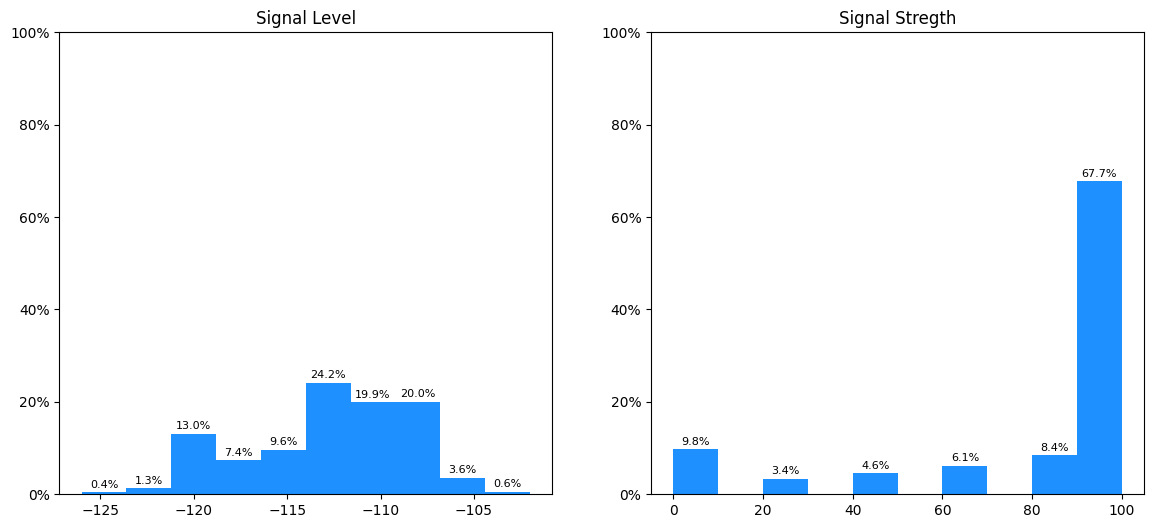

In [49]:
# Understand data behavior using hist

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(df_signal_crude["Signal Level"], 
         weights=np.ones(len(df_signal_crude["Signal Level"])) / len(df_signal_crude["Signal Level"]),
         color = "dodgerblue")
ax1.set_title("Signal Level")

ax2.hist(df_signal_crude["Signal Stregth"], 
         weights=np.ones(len(df_signal_crude["Signal Stregth"])) / len(df_signal_crude["Signal Stregth"]),
         color = "dodgerblue")
ax2.set_title("Signal Stregth")

for ax in [ax1, ax2]:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_ylim(0,1)

for ax in [ax1, ax2]:
    for rect in ax.patches:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', fontsize=8)


fig.set_size_inches(14, 6)

plt.show()

In [50]:
# Categorizating data with three categories: ideal (best condition of signal), operacional (intermediate transmission), non-operation (no data transfer)

column_signal_level_cat = []
column_signal_stregth = df_signal_crude["Signal Stregth"].to_list()
column_signal_level = df_signal_crude["Signal Level"].to_list()

for i in range(0,len(column_signal_level)):
    
    if int(column_signal_level[i]) >= -110:

        column_signal_level_cat.append("Ideal")

    elif int(column_signal_level[i]) < -110 and int(column_signal_level[i]) >= -120:

        column_signal_level_cat.append("Operational")

    else:
        column_signal_level_cat.append("Non-operational")

df_signal_crude["Signal Level Categorization"] = column_signal_level_cat


Map analysis

In [51]:
# Reading json with polygons 
sb_path = gpd.read_file("../Estudo SBs/sb_map.json")

# Generating GeoDataframe
geodataframe = gpd.GeoDataFrame(sb_path)


In [52]:
# Converting Lat e Long to geometric point
geometric_points = []

for xy in zip(df_signal_crude["Longitude"], df_signal_crude['Latitude']):
    geometric_points.append(Point(xy))

geo_location = gpd.GeoDataFrame(df_signal_crude,
                                    crs='epsg:4326',
                                    geometry = geometric_points)

In [53]:
# Verify if the points is inside of map
location = []
ponto = geo_location["geometry"].to_list()

valor_procurado = True

for i in range(0, len(df_signal_crude)):
    
    check = geodataframe["geometry"].contains(ponto[i]).values
    
    index = np.where(check == valor_procurado)[0]
    
    if index.size > 0:
        location.append(geodataframe["name"][index[0]])
    else:
        location.append("NotFound")

In [54]:
df_signal_converted = df_signal_crude.assign(Location = location)

In [56]:
# grouping location by register from signal level to use in time calc
location_by_signal_level = df_signal_converted.groupby(["Location"])["Signal Level"].mean()

#getting unique values from location
exclusive_location_level = location_by_signal_level.index.get_level_values("Location").unique()
arr_exclusive_location_level = exclusive_location_level.to_numpy()

data_dict_signal_level_mean = {"name": [], "Mean Signal Level": []}

# Iterando sobre os índices e valores da série
for index, value in location_by_signal_level.items():
        
        data_dict_signal_level_mean["name"].append(index)
        data_dict_signal_level_mean["Mean Signal Level"].append(value)

df_signal_level_by_mean_crude = pd.DataFrame(data_dict_signal_level_mean)

# grouping location by register from signal level to use in time calc
location_by_signal_strength = df_signal_converted.groupby(["Location"])["Signal Stregth"].mean()

#getting unique values from location
exclusive_location_strength = location_by_signal_strength.index.get_level_values("Location").unique()
arr_exclusive_location_strength = exclusive_location_strength.to_numpy()

data_dict_signal_strength_mean = {"name": [], "Mean Signal Strength": []}

# Iterando sobre os índices e valores da série
for index, value in location_by_signal_strength.items():
        
        data_dict_signal_strength_mean["name"].append(index)
        data_dict_signal_strength_mean["Mean Signal Strength"].append(value)

df_signal_strength_by_mean_crude = pd.DataFrame(data_dict_signal_strength_mean)

df_signal_mean_by_location = df_signal_level_by_mean_crude.merge(df_signal_strength_by_mean_crude, on="name")


It was creat a df sorted to visualize the worst and best area by signal

In [58]:
# grouping location by register from time
location_by_time = df_signal_converted.groupby(["Location", "Signal Level Categorization"])["Time Count"].sum()

exclusive_location_time = location_by_time.index.get_level_values("Location").unique()
arr_exclusive_location_time = exclusive_location_time.to_numpy()

data_dict_time_sum = {"name": [], "Signal Range": [], "Time": []}

for index, value in location_by_time.items():

        data_dict_time_sum["name"].append(index[0])
        data_dict_time_sum["Signal Range"].append(index[1])
        data_dict_time_sum["Time"].append(value)

df_time_by_mean_crude = pd.DataFrame(data_dict_time_sum)

df_time_by_mean_pivot = df_time_by_mean_crude.pivot_table(index='name', columns='Signal Range', values='Time', fill_value=0).reset_index()


# Generating df with categorization by polygon
df_time_by_mean_pivot = df_time_by_mean_pivot.rename_axis(None, axis='columns')


Time analysis

In [61]:
# Finding test duration

time_ideal = df_time_by_mean_pivot["Ideal"].sum()
time_non_operational = df_time_by_mean_pivot["Non-operational"].sum()
time_operational = df_time_by_mean_pivot["Operational"].sum()

label_time = df_signal_converted["Signal Level Categorization"].unique()

total_time = (time_ideal + time_non_operational + time_operational)/3600

test_duration_1 = (df_signal_converted["Date"][10050] - df_signal_converted["Date"][0]).total_seconds()

h = test_duration_1//3600
m = (test_duration_1%3600)//60
sec =(test_duration_1%3600)%60

print("Test duration: 0%d:0%d:%d" %(h,m,sec))

Test duration: 07:07:54


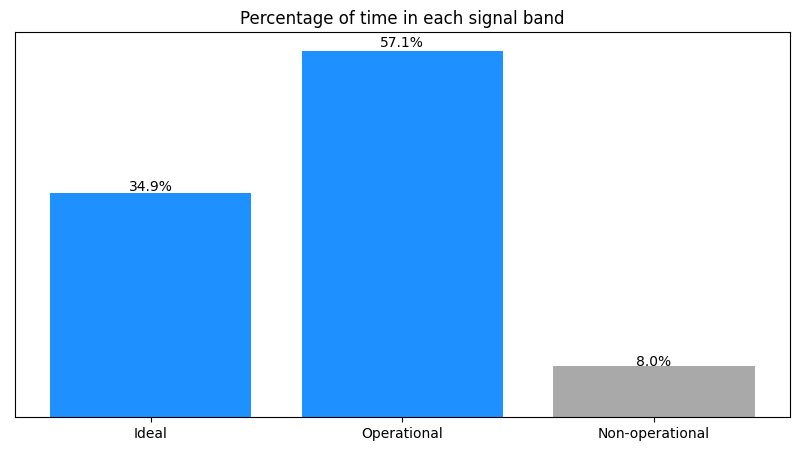

In [63]:
# Defining how many time the device worked per band
percentage = [((time_ideal/3600)*100)/total_time,((time_operational/3600)*100)/total_time, ((time_non_operational/3600)*100)/total_time]
time_value = [time_ideal/3600,time_operational/3600,time_non_operational/3600]

plt.figure(figsize=(10, 5))

colors_list = ['dodgerblue','dodgerblue', 'darkgray']
graph = plt.bar(label_time,time_value, color = colors_list)
plt.title("Percentage of time in each signal band")

plt.yticks([])

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(round(percentage[i],1))+'%',
             ha='center',
             )
    i+=1
    
plt.show()

In [64]:
# Generating index from exclusive location with data from
index_exclusive_location_in_geojson = []

for geo in range(0,len(geodataframe)):
    
    for exclusive in range(0, len(exclusive_location_level)):

        if(geodataframe["name"][geo] == exclusive_location_level[exclusive]):
            
            index_exclusive_location_in_geojson.append(geo)

# Generating a dataframe with uniques values with data --------> To use in map
geodataframe_filtered_values = geodataframe.iloc[index_exclusive_location_in_geojson].reset_index(drop=True)

geodataframe_count_network = pd.merge(geodataframe_filtered_values, df_signal_mean_by_location, on='name',how='left')
geodataframe_count_network = geodataframe_count_network.dropna()


In [65]:
# Getting the columns names to usa like label in map
labels_name = ["name"]
labels_m0 = ["name"]

for i in range(1,len(df_signal_mean_by_location.columns)):
    labels_name.append(str(df_signal_mean_by_location.columns[i]))
    labels_m0.append(str(df_signal_mean_by_location.columns[i]))


In [66]:
# Creating an especific dataframe to use in the heatmap
df_heatmap = pd.DataFrame()
df_heatmap["Latitude"] = df_signal_converted["Latitude"]
df_heatmap["Longitude"] = df_signal_converted["Longitude"]
df_heatmap["Signal Level"] = df_signal_converted["Signal Level"]

In [72]:
# Generating map
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    }

# Generating map for MU17

m = folium.Map(location=[df_signal_converted["Latitude"].mean(),df_signal_converted["Longitude"].mean()], zoom_start=10, tiles=basemaps["Google Maps"])
folium.Choropleth(
    geo_data=geodataframe_count_network,
    data=df_signal_mean_by_location,
    columns= ["name", "Mean Signal Level"],
    key_on="feature.properties.name",
    bins=[-125, -120, -115, -110, -90],
    fill_color="RdYlGn",
    fill_opacity=0.6,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Mean Signal Level",
).add_to(m)

style_function = lambda x: {'fillColor': 'RdYlGn', 'fillOpacity': 0,  'weight': 0.1}
highlight_function = lambda x: {'fillColor': 'RdYlGn', 'fillOpacity': 0.1, 'weight': 0.1}

layer = folium.features.GeoJson(
    geodataframe_count_network,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=labels_m0,
        aliases=labels_name,
        localize=True,
    )
)

for i in basemaps:
    basemaps[i].add_to(m)

HeatMap(df_heatmap, 
        min_opacity=0.6,
        blur = 18,
        radius = 14, 
        max_zoom=12,
        
        ).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))

folium.LayerControl().add_to(m)
